## Import Packages Etc

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import hamming_loss, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.validation import check_is_fitted
# import other useful packages

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Task 0: Load the Yeast Dataset

In [0]:
dataset = pd.read_csv('yeast.csv')
data = np.array(dataset.iloc[:,:103])
functions = np.array(dataset.iloc[:,103:])

Explore the dataset

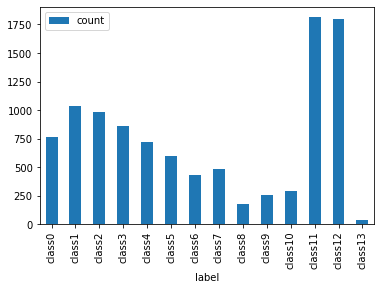

In [0]:
# visualize the number of the label
tag_dict ={}
num_classes = 14
for i in range(num_classes):
    tag_dict['class'+ i.__str__()] = dataset.iloc[:,103+i].value_counts()[1]
labelcount = pd.DataFrame(list(tag_dict.items()),columns=['label', 'count'])
labelcount.plot(x='label', y='count', kind='bar')
plt.show()

## Task 1: Implement the Binary Relevance Algorithm

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, add_noise = False):
        self.add_noise = add_noise
        
    # The fit function to train a classifier
    def fit(self, data, functions):    
        # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()

        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T
            self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(data, status)
        
        # Return the classifier
        return self
            
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])

        # Initialise an empty list to store the predictions made
        pos_functions = list()
        
        # Iterate all functioins to predict
        for i in range(14):
            pos_functions.append(self.relevances_[i].predict(X))
            
        return np.array(pos_functions).T

## Task 2: Implement the Binary Relevance Algorithm with Under-Sampling

In [0]:
class BRUnderSample(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, under_sampling='undersampling', algorithm_model = 'BaggingClassifier'):
        self.under_sampling = under_sampling
        self.algorithm_model = algorithm_model
        
    # The fit function to train a classifier
    def fit(self, data, functions):
         # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()
        
        # Add an option to under-sample
        rus = RandomUnderSampler(random_state=0)
        
        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T

            # option to under-sample
            if self.under_sampling == 'undersampling':
                temp_data, status = rus.fit_sample(data,status)
            else:
                temp_data = data
                
            # Choose algorithm
            if self.algorithm_model == 'BaggingClassifier':
                self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(temp_data, status)
            elif self.algorithm_model == 'LogisticRegression':
                self.relevances_[i] = BaggingClassifier(base_estimator = linear_model.LogisticRegression(),n_estimators=10).fit(temp_data, status)
            elif self.algorithm_model == 'DecisionTree':
                self.relevances_[i] = BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200),n_estimators=10).fit(temp_data, status)
            elif self.algorithm_model == 'KNN':
                self.relevances_[i] = BaggingClassifier(base_estimator = neighbors.KNeighborsClassifier(n_neighbors =2),max_samples=0.1,max_features=0.5).fit(temp_data,status)

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])
        
        # Initialise an empty list to store the predictions made
        pos_functions = list()

        # Iterate all functioins to predict
        for  i in range(14):
            pos_functions.append(self.relevances_[i].predict(X))
            
        return np.array(pos_functions).T

## Task 3: Compare the Performance of Different Binary Relevance Approaches

### Split the data into a training and a test set

In [0]:
data_train, data_test, function_train, function_test = train_test_split(data, functions, random_state=0, train_size = 0.7)

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train and evaluate 2 models

Binary Relevance Model

In [0]:
br = BinaryRelevanceClassifier()
br.fit(data_train, function_train)
function_pred = br.predict(data_test)

# The number of subset whose labels exactly match the corresponding set of labels
brAccuracy = accuracy_score(function_test, function_pred)
# The fraction of labels that are incorrectly predicted
brLoss = hamming_loss(function_test, function_pred)
# F1 score: weighted average of the precision and recall
brfScore = f1_score(function_test, function_pred, average='macro')

Binary Relevance Model with under-sampling

In [0]:
bru = BRUnderSample()
bru.fit(data_train, function_train)
function_pred = bru.predict(data_test)

bruAccuracy = accuracy_score(function_test, function_pred)
bruLoss = hamming_loss(function_test, function_pred)
brufScore = f1_score(function_test, function_pred, average='macro')

Plot the performance of 2 models

The accuracy of Binary Relevance is 0.114325 and Binary Relevance with under-sampling is 0.046832


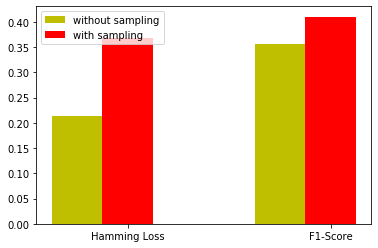

In [0]:
print("The accuracy of Binary Relevance is %f and Binary Relevance with under-sampling is %f"%(brAccuracy,bruAccuracy))

name_list = ['Hamming Loss','F1-Score']
num_list = [brLoss,brfScore]
num_list1 = [bruLoss,brufScore]
x = list(range(len(num_list)))
total,n = 0.5, 2
width = total / n

plt.bar(x, num_list, width = width, label ='without sampling',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width = width, label ='with sampling',tick_label = name_list,fc = 'r')
plt.legend()
plt.show()

### Other models

Logistic Regression, Desicion Tree, Nearest Neighbour

In [0]:
param_grid = [
 {'under_sampling': ['undersampling','naturesampling'],
 'algorithm_model': ['BaggingClassifier','LogisticRegression','DecisionTree','KNN']}
]
cv_folds = 2
my_tuned_model = GridSearchCV(BRUnderSample(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(data_train, function_train)
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list = dict()
model_tuned_params_list["Tuned model"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

function_pred = my_tuned_model.predict(data_test)

# The fraction of labels that are incorrectly predicted
tunedLoss = hamming_loss(function_test, function_pred)
print(tunedLoss)
# F1 score: weighted average of the precision and recall
tunedfScore = f1_score(function_test, function_pred, average='macro')
print(tunedfScore)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] algorithm_model=BaggingClassifier, under_sampling=undersampling .
[CV]  algorithm_model=BaggingClassifier, under_sampling=undersampling, total=   1.9s
[CV] algorithm_model=BaggingClassifier, under_sampling=undersampling .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  algorithm_model=BaggingClassifier, under_sampling=undersampling, total=   1.7s
[CV] algorithm_model=BaggingClassifier, under_sampling=naturesampling 
[CV]  algorithm_model=BaggingClassifier, under_sampling=naturesampling, total=   7.2s
[CV] algorithm_model=BaggingClassifier, under_sampling=naturesampling 
[CV]  algorithm_model=BaggingClassifier, under_sampling=naturesampling, total=   7.0s
[CV] algorithm_model=LogisticRegression, under_sampling=undersampling 
[CV]  algorithm_model=LogisticRegression, under_sampling=undersampling, total=   0.4s
[CV] algorithm_model=LogisticRegression, under_sampling=undersampling 
[CV]  algorithm_model=LogisticRegression, under_sampling=undersampling, total=   0.4s
[CV] algorithm_model=LogisticRegression, under_sampling=naturesampling 
[CV]  algorithm_model=LogisticRegression, under_sampling=naturesampling, total=   0.9s
[CV] algorithm_model=LogisticRegression, under_sampling=naturesampling 
[CV]  algorithm_model=LogisticRegression, under_sampling

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   28.1s finished


Best parameters set found on development set:
{'algorithm_model': 'LogisticRegression', 'under_sampling': 'naturesampling'}
0.13719692489651095
0.2082841401023219
0.33712718203098674


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Task 4: Implement the Classifier Chains Algorithm

In [0]:
# Write your code here
class ClassChainsClassifier(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, add_noise = False):
        self.add_noise = add_noise
        
    # The fit function to train a classifier
    def fit(self, data, functions):
        data = data[:,:103]
        # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()

        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T
            self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(data, status)
            data = np.c_[data,status]
            
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])

        # Initialise an empty list to store the predictions made
        pos_functions = list()
        
        # Iterate all functioins to predict
        for i in range(14):
            j = 103+i
            pos_functions.append(self.relevances_[i].predict(X[:,:j]))
            
        return np.array(pos_functions).T

## Task 5: Evaluate the Performance of the Classifier Chains Algorithm

### Split the data into a training and a test set

In [0]:
data_cc = np.array(dataset)
data_cc_train, data_cc_test, function_cc_train, function_cc_test = train_test_split(data_cc, functions, random_state=0, train_size = 0.7)

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train and evaluate Classifier Chain Algorithm

In [0]:
cc = ClassChainsClassifier()
cc.fit(data_cc_train, function_cc_train)
function_pred = cc.predict(data_cc_test)

ccAccuracy = accuracy_score(function_cc_test, function_pred)
ccLoss = hamming_loss(function_cc_test, function_pred)
ccfScore = f1_score(function_test, function_pred, average='macro')

E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Plot the performance of 3 models

The accuracy of Binary Relevance is 0.114325
Binary Relevance with under-sampling is 0.046832
Classifier Chain is 0.195592



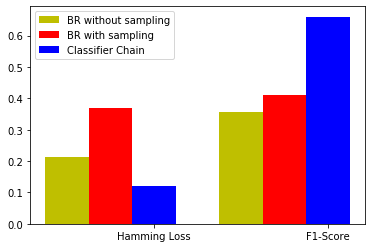

In [0]:
print("The accuracy of Binary Relevance is %f\nBinary Relevance with under-sampling is %f\nClassifier Chain is %f\n"%(brAccuracy,bruAccuracy,ccAccuracy))

name_list = ['Hamming Loss','F1-Score']
num_list = [brLoss,brfScore]
num_list1 = [bruLoss,brufScore]
num_list2 = [ccLoss,ccfScore]
x = list(range(len(num_list)))
total,n = 0.5, 2
width = total / n

plt.bar(x, num_list, width = width, label ='BR without sampling',fc = 'y')
for i in range(len(x)):
    x[i] += width
plt.bar(x, num_list1, width = width, label ='BR with sampling',tick_label = name_list,fc = 'r')
for i in range(len(x)):
    x[i] += width
plt.bar(x, num_list2, width = width, label ='Classifier Chain',tick_label = name_list,fc = 'b')
plt.legend()
plt.show()

## Task 6: Reflect on the Performance of the Different Models Evaluated

The bar chart above shows the performance of the 3 models. It illustrates that Classifier Chain works best for both evaluation indexes. The Hamming Loss is much lower than other twos', while the F1-Score is much higher. It means that the Classifier Chain predicts the least incorrect labels and have the highest average precision and recall among these 3 models. Thus, as far as this dataset, considering other function classes do the effort to predict the specific class correctly.  
However, it's hard to say whether under-sampling improves the performance of Binary Relevance model. Though the F1-Score becomes higher after under-sampling, the Hamming loss increases as well. It shows that under-sampling help the model get higher recall though it predicts more incorrect labels. It might because when under-sample dataset with week features randomly, the simple classifier, for example, decision tree, will be trained worse as it lost many data for judgement.
For binary relevance algorithm and classifer chains algorithm, the classifer training process fits 23688 instances to build the model whereas only 10083 instances are processed after undersampling. According to the results of grid search, it shows with normal sample and undersampling sample the running time has huge difference. What's more, in the undersampling binary relevance part, we add options to choose base algorithm and undersampling, sum up to 8 combinations. The combinations are not too much to make model too complex. 
